## Weekly Return

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/TSLA.csv')
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume']
df.drop(columns=columns_to_drop, inplace=True)

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set date as index
df.set_index('Date', inplace=True)

# Filter out data before 2016
df = df[df.index.year >= 2016]

# Calculate the end of week dates
df['Week'] = df.index.to_series().dt.isocalendar().week
df['Year'] = df.index.to_series().dt.isocalendar().year
df['Month'] = df.index.month  # Add Month column
df['DateStr'] = df.index.strftime('%y%m%d')
df['TradingWeek'] = (
    df['Year'].astype(str) + '-' 
    + df['Week'].astype(str).apply(lambda x: str(x).zfill(2))
)

# Filter out the end trading day of each week
weekly_df = df.groupby('TradingWeek').last()
# Calculate the last Friday's close price
weekly_df['PrevClose'] = weekly_df['Adj Close'].shift(1)

pages = 5
pd.concat([weekly_df.head(pages), weekly_df.tail(pages)])


,Adj Close,Week,Year,Month,DateStr,PrevClose
TradingWeek,,,,,,
2016-01,14.066667,1,2016,1,160108,NaN
2016-02,13.666000,2,2016,1,160115,14.066667
2016-03,13.503333,3,2016,1,160122,13.666000
2016-04,12.746667,4,2016,1,160129,13.503333
2016-05,10.840000,5,2016,2,160205,12.746667
2024-10,175.339996,10,2024,3,240308,202.639999
2024-11,163.570007,11,2024,3,240315,175.339996
2024-12,170.830002,12,2024,3,240322,163.570007
2024-13,175.789993,13,2024,3,240328,170.830002


## Strategy Construction

In [59]:
# Define strike_factor, premium, and leverage
strike_factor = 1.15  # Assuming 115% increase triggers a loss
premium = 0.005
leverage = 1.0  # Adjust leverage as needed

# Initialize an empty list to store profits
profits = []

# Iterate over the DataFrame to calculate profits
for i in range(1, len(weekly_df)):
    prev_close = weekly_df.iloc[i - 1]['Adj Close']
    this_close = weekly_df.iloc[i]['Adj Close']
    
    if this_close <= prev_close * strike_factor:
        profit = prev_close * premium
    else:
        profit = prev_close * premium - leverage * (this_close - prev_close * strike_factor)
    
    profits.append(profit)

# Add profits to the DataFrame
weekly_df['Profit'] = [0.0] + profits
weekly_df['Cumulative_Profit'] = weekly_df['Profit'].cumsum()

# Display the DataFrame with profit column
pages = 5
pd.concat([weekly_df.head(pages), weekly_df.tail(pages)])

,Adj Close,Week,Year,Month,DateStr,PrevClose,Profit,Cumulative_Profit
TradingWeek,,,,,,,,
2016-01,14.066667,1,2016,1,160108,NaN,0.000000,0.000000
2016-02,13.666000,2,2016,1,160115,14.066667,0.070333,0.070333
2016-03,13.503333,3,2016,1,160122,13.666000,0.068330,0.138663
2016-04,12.746667,4,2016,1,160129,13.503333,0.067517,0.206180
2016-05,10.840000,5,2016,2,160205,12.746667,0.063733,0.269913
2024-10,175.339996,10,2024,3,240308,202.639999,1.013200,113.031890
2024-11,163.570007,11,2024,3,240315,175.339996,0.876700,113.908590
2024-12,170.830002,12,2024,3,240322,163.570007,0.817850,114.726440
2024-13,175.789993,13,2024,3,240328,170.830002,0.854150,115.580590


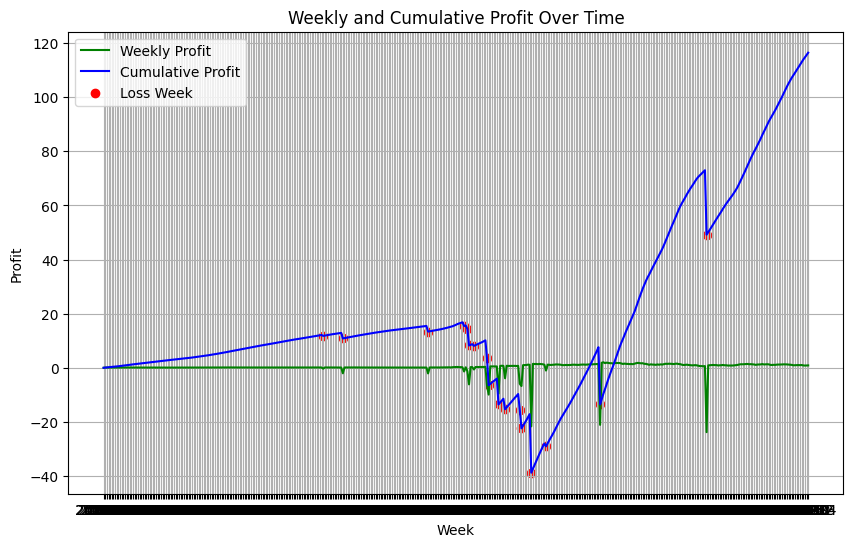

In [60]:
import matplotlib.pyplot as plt

# Plotting the profit and cumulative profit
plt.figure(figsize=(10, 6))

# Plotting the profit
plt.plot(weekly_df.index, weekly_df['Profit'], label='Weekly Profit', color='green')

# Plotting the cumulative profit
plt.plot(weekly_df.index, weekly_df['Cumulative_Profit'], label='Cumulative Profit', color='blue')

# Identifying and highlighting the weeks with negative profits
loss_weeks = weekly_df[weekly_df['Profit'] < 0].index
plt.scatter(loss_weeks, weekly_df.loc[loss_weeks, 'Cumulative_Profit'], color='red', label='Loss Week')

plt.xlabel('Week')
plt.ylabel('Profit')
plt.title('Weekly and Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
# Filter the DataFrame to get rows corresponding to loss weeks before updating
loss_weeks_before = weekly_df[weekly_df['Profit'] < 0]

# Print the loss table before updating
loss_weeks_before

,Adj Close,Week,Year,Month,DateStr,PrevClose,Profit,Cumulative_Profit
TradingWeek,,,,,,,,
2018-31,23.211332,31,2018,8,180803,19.812000,-0.328472,11.792095
2018-43,22.059999,43,2018,10,181026,17.333332,-2.040001,10.844321
2019-43,21.875334,43,2019,10,191025,17.129999,-2.090185,13.368119
2020-13,34.290668,13,2020,3,200327,28.502001,-1.370857,15.441535
2020-15,38.200001,15,2020,4,200409,32.000668,-1.239229,14.373759
2020-16,50.259335,16,2020,4,200417,38.200001,-6.138334,8.235425
2020-19,54.627998,19,2020,5,200508,46.754665,-0.626360,8.102079
2020-27,80.577332,27,2020,7,200702,63.982666,-6.677353,3.455496
2020-28,102.976669,28,2020,7,200710,80.577332,-9.909851,-6.454355


# Strategy Optimization with loss week 

## Optimize with Events(Delivery & Earnings)

In [62]:
import pandas as pd

# Earnings dates
earnings_dates = pd.to_datetime([
    '7/19/23', '4/19/23', '1/25/23', '10/19/22', '7/20/22', '4/20/22', '1/26/22', '10/20/21', 
    '7/26/21', '4/26/21', '1/27/21', '10/21/20', '7/22/20', '4/29/20', '1/29/20', '10/23/19', 
    '6/24/19', '4/24/19', '1/30/19', '10/24/18', '8/1/18', '5/2/18', '2/7/18', '11/1/17', 
    '8/2/17', '5/3/17', '2/22/17', '10/26/16', '8/3/16', '5/4/16'
])

# Calculate trading week string for each earnings date
earnings_trading_weeks = [
    f"{date.isocalendar()[0]}-{str(date.isocalendar()[1]).zfill(2)}"
    for date in earnings_dates
]

# Find the intersection of trading weeks
intersection = set(earnings_trading_weeks).intersection(set(weekly_df.index))

# Print the intersection
print("Intersection of Trading Weeks:")
print(intersection)


Intersection of Trading Weeks:
{'2023-04', '2018-43', '2022-16', '2022-04', '2022-29', '2019-43', '2019-26', '2017-44', '2017-31', '2017-08', '2020-30', '2020-18', '2021-17', '2019-05', '2019-17', '2020-43', '2017-18', '2021-30', '2018-31', '2021-42', '2021-04', '2020-05', '2016-18', '2016-43', '2018-06', '2023-16', '2018-18', '2016-31', '2022-42', '2023-29'}


/var/folders/1k/xjqy__5j3gg35387ft__8k540000gn/T/ipykernel_7547/1573185063.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  earnings_dates = pd.to_datetime([


In [65]:
# Iterate over the index of weekly_df and set the trading week loss to 0 if there is a conjunction
for trading_week in weekly_df.index:
    if trading_week in intersection:
        weekly_df.loc[trading_week, 'Profit'] = 0

# Update the cumulative profit column
weekly_df['Cumulative_Profit'] = weekly_df['Profit'].cumsum()

# Filter the DataFrame to get rows corresponding to loss weeks after updating
loss_weeks_after = weekly_df[weekly_df['Profit'] < 0]
loss_weeks_after


,Adj Close,Week,Year,Month,DateStr,PrevClose,Profit,Cumulative_Profit
TradingWeek,,,,,,,,
2020-13,34.290668,13,2020,3,200327,28.502001,-1.370857,18.664430
2020-15,38.200001,15,2020,4,200409,32.000668,-1.239229,17.596654
2020-16,50.259335,16,2020,4,200417,38.200001,-6.138334,11.458320
2020-19,54.627998,19,2020,5,200508,46.754665,-0.626360,11.083257
2020-27,80.577332,27,2020,7,200702,63.982666,-6.677353,6.436674
2020-28,102.976669,28,2020,7,200710,80.577332,-9.909851,-3.473177
2020-34,136.665329,34,2020,8,200821,110.047333,-9.560659,-11.085463
2020-38,147.383331,38,2020,9,200918,124.239998,-3.886133,-12.853269
2020-47,163.203339,47,2020,11,201120,136.166672,-5.930833,-13.888769


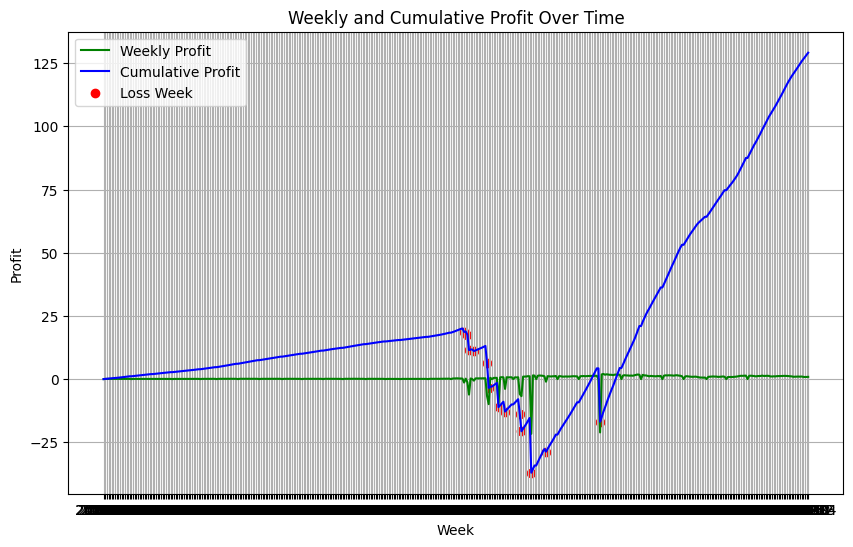

In [66]:
import matplotlib.pyplot as plt

# Plotting the profit and cumulative profit
plt.figure(figsize=(10, 6))

# Plotting the profit
plt.plot(weekly_df.index, weekly_df['Profit'], label='Weekly Profit', color='green')

# Plotting the cumulative profit
plt.plot(weekly_df.index, weekly_df['Cumulative_Profit'], label='Cumulative Profit', color='blue')

# Identifying and highlighting the weeks with negative profits
loss_weeks = weekly_df[weekly_df['Profit'] < 0].index
plt.scatter(loss_weeks, weekly_df.loc[loss_weeks, 'Cumulative_Profit'], color='red', label='Loss Week')

plt.xlabel('Week')
plt.ylabel('Profit')
plt.title('Weekly and Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.show()


## Optimization with Implied Vol